# 11-1. 自然言語処理分野➀

### テーマ：Seq2Seqを利用した日英翻訳モデル実装

> dataset: [JESC](https://nlp.stanford.edu/projects/jesc/)([利用規約](https://creativecommons.org/licenses/by-sa/4.0/)) or [Tatoeba](https://www.google.com/url?q=https://tatoeba.org/en/downloads&sa=D&source=editors&ust=1631510899880000&usg=AOvVaw0YRm5zQdeRg0PYZXMgjuMq)([利用規約](https://tatoeba.org/en/terms_of_use))

所要時間：<font color="Red">5~8時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [49]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install tensorflow==2.8.0 nltk==3.6.5 janome==0.4.1
else:
    print("Not Google Colab")

Not Google Colab


### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [50]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Not Google Colab


## ライブラリのインポート

In [51]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tarfile
import math
import io
import urllib.request

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import metrics, Sequential
from keras.layers import Input, Dense, Embedding, LSTM, Softmax, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42

### データセットの用意

今回使用するデータセットはJapanese-English Subtitle Corpus(JESC)という、映画やTV番組の字幕データです。

英日対応されている文が2,800,439文用意されています。

今回は時間短縮のため、1000データのみ読み込んで使用します。

In [52]:
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マイドライブ内のデータを読み込むpathに設定
    jesc_path = '/content/drive/MyDrive/data_jesc.csv'
else:
    jesc_path = 'data_jesc.csv'

# データセットの読み込み
raw_df = pd.read_csv(jesc_path)

データセットの中身を確認しましょう。

In [53]:
raw_df.head()

,英語,日本語
0,"you are back, aren't you, harold?",あなたは戻ったのね ハロルド?
1,my opponent is shark.,俺の相手は シャークだ。
2,this is one thing in exchange for another.,引き換えだ ある事とある物の
3,"yeah, i'm fine.",もういいよ ごちそうさま ううん
4,don't come to the office anymore. don't call m...,もう会社には来ないでくれ 電話もするな


次に、英語文と日本語文それぞれをトークン化します。
そのための準備として、英語文を格納したリスト`en_sentences`と日本語文を格納したリスト`ja_sentences`を準備しましょう。

In [54]:
en_sentences = raw_df['英語'].values
ja_sentences = raw_df['日本語'].values

今回は英語の文をトークン化するnltkライブラリを使用します。

例えば、

`my opponent is shark.`

は

`"my", "opponent", "is", "shark", "."`

と分割されます。

nltkライブラリを使用し、実際に英語の文をトークン化しましょう。

In [55]:
import nltk 
from nltk import tokenize
nltk.download('punkt')

def tokenize_en(sentences_list):
    tokenize_list = []
    for sentence in sentences_list:
        tokenize_list.append(tokenize.word_tokenize(sentence))
    return tokenize_list
en_sentences = tokenize_en(en_sentences)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mssst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
tokenize_en(["my opponent is shark."])

[['my', 'opponent', 'is', 'shark', '.']]

日本語の文はjanomeライブラリを使用してトークン化します。

例えば、

`俺の名前はシャークだ。` 

は

`"俺", "の", "名前", "は", "シャーク", "だ", "。"`

と分割されます。

janomeライブラリを使用し、実際に日本語の文をトークン化しましょう。

In [57]:
from janome.tokenizer import Tokenizer
wakati = Tokenizer()

def tokenize_ja(sentences_list):
    wakati_list = []
    for sentence in sentences_list:
        wakati_list.append([item.surface for item in wakati.tokenize(sentence)])
    return wakati_list
ja_sentences = tokenize_ja(ja_sentences)

In [58]:
tokenize_ja(["俺の名前はシャークだ。"])

[['俺', 'の', '名前', 'は', 'シャーク', 'だ', '。']]

トークン化された単語はそのまま学習などの処理を行うことが出来ません。

そのため、各単語を数値IDへと変換する必要があります。

例えば、

`"Is", "this", "a", "pen", "?", "This", "is", "a", "pen", "."`

を

`0 1 2 3 4 1 0 2 3 5 `

という数値の羅列へと変換します。

In [59]:
# 単語をIDに変換する単語辞書を生成する
def create_word_id_dict(sentences):
    word_to_id, id_to_word = {}, {}
    for sentence in sentences:
        for word in sentence:
            if word not in word_to_id:
                tmp_id = len(word_to_id)+1
                word_to_id[word] = tmp_id
                id_to_word[tmp_id] = word
    return word_to_id, id_to_word

# 文章をID列に変換する
def convert_sentences_to_ids(sentences, word_to_id):
    sentence_id = []
    for sentence in sentences:
        sentence_ids = []
        for word in sentence:
            if word in word_to_id:
                sentence_ids.append(word_to_id[word])
            else:
                sentence_ids.append(0)
        sentence_id.append(sentence_ids)
    return sentence_id

def padding_sentence(sentences):
    max_sentence_size = 0
    for sentence in sentences:
        if max_sentence_size < len(sentence):
            max_sentence_size = len(sentence)
    for sentence in sentences:
        while len(sentence) < max_sentence_size:
            sentence.insert(0,0)
    return sentences

In [47]:
# en_word_to_id, en_id_to_word = create_word_id_dict(en_sentences)
# en_sentences = convert_sentences_to_ids(en_sentences, en_word_to_id)
# en_sentences = padding_sentence(en_sentences)

# ja_word_to_id, ja_id_to_word = create_word_id_dict(ja_sentences)
# ja_sentences = convert_sentences_to_ids(ja_sentences, ja_word_to_id)
# ja_sentences = padding_sentence(ja_sentences)

In [60]:
en_word_to_id, en_id_to_word = create_word_id_dict(en_sentences)
print(en_word_to_id)
print(en_word_to_id['shark'])

{'you': 1, 'are': 2, 'back': 3, ',': 4, "n't": 5, 'harold': 6, '?': 7, 'my': 8, 'opponent': 9, 'is': 10, 'shark': 11, '.': 12, 'this': 13, 'one': 14, 'thing': 15, 'in': 16, 'exchange': 17, 'for': 18, 'another': 19, 'yeah': 20, 'i': 21, "'m": 22, 'fine': 23, 'do': 24, 'come': 25, 'to': 26, 'the': 27, 'office': 28, 'anymore': 29, 'call': 30, 'me': 31, 'either': 32, 'looks': 33, 'beautiful': 34, 'get': 35, 'him': 36, 'out': 37, 'of': 38, 'here': 39, 'because': 40, 'will': 41, 'fucking': 42, 'kill': 43, 'killed': 44, '!': 45, 'okay': 46, 'then': 47, 'who': 48, 'it': 49, 'seems': 50, 'a': 51, 'former': 52, 'employee': 53, '...': 54, 'so': 55, 'where': 56, 'they': 57, 'or': 58, 'know': 59, 'just': 60, 'no': 61, 'child': 62, 'should': 63, 'ever': 64, 'have': 65, 'endure': 66, 'that': 67, 'visual': 68, "'s": 69, 'incongruous': 70, 'but': 71, 'aw': 72, 'let': 73, 'show': 74, 'more': 75, 'detailed': 76, 'ones': 77, "'re": 78, 'gon': 79, 'na': 80, 'bring': 81, 'up': 82, 'right': 83, 'now': 84, 'w

In [61]:
# 文章をID列に変換する
print(en_sentences[1])
en_sentences = convert_sentences_to_ids(en_sentences, en_word_to_id)
print(en_sentences[1])

['my', 'opponent', 'is', 'shark', '.']
[8, 9, 10, 11, 12]


In [38]:
en_sentences = np.array(en_sentences)
print(type(en_sentences))

<class 'numpy.ndarray'>


In [62]:
# 余白に0を挿入する(文字列の長さをサンプル間で一定にするため)

## padding_sentence()を行う前は文字列の長さが異なる
print(en_sentences[0])
print(en_sentences[1])

## padding_sentence()を行った後は文字列の長さが一緒になる
en_sentences = padding_sentence(en_sentences)
print(en_sentences[0])
print(en_sentences[1])

[1, 2, 3, 4, 2, 5, 1, 4, 6, 7]
[8, 9, 10, 11, 12]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 2, 5, 1, 4, 6, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 10, 11, 12]


In [63]:
# numpy.ndarrayの型に変換する
en_sentences = np.array(en_sentences)
print(type(en_sentences))

<class 'numpy.ndarray'>


In [64]:
# 日本語文章も同様
ja_word_to_id, ja_id_to_word = create_word_id_dict(ja_sentences) # 単語をIDに変換する単語辞書を生成する
ja_sentences = convert_sentences_to_ids(ja_sentences, ja_word_to_id) # 文章をID列に変換する
ja_sentences = padding_sentence(ja_sentences) # 余白に0を挿入する(文字列の長さをサンプル間で一定にするため)
ja_sentences = np.array(ja_sentences) # numpy.ndarrayの型に変換する

In [ ]:
# en_word_to_id, en_id_to_word = create_word_id_dict(en_sentences)
# en_sentences = convert_sentences_to_ids(en_sentences, en_word_to_id)
# en_sentences = padding_sentence(en_sentences)

# ja_word_to_id, ja_id_to_word = create_word_id_dict(ja_sentences)
# ja_sentences = convert_sentences_to_ids(ja_sentences, ja_word_to_id)
# ja_sentences = padding_sentence(ja_sentences)

また今回、Seq2SeqやTransformerをTensorFlowで実装します。

TensorFlowで実装する場合、データをTensor型で扱う必要があります。

そのため、関数`tf.constant()`を使用して学習データおよび評価データをTensor型へ変換します。

In [65]:
en_sentences = tf.constant(en_sentences)
ja_sentences = tf.constant(ja_sentences)


# 説明変数(英語文データ)
print(en_sentences.shape)
#目的変数(日本語文データ)の確認
print(ja_sentences.shape)

(1000, 43)
(1000, 57)


## Seq2Seqを用いた日英翻訳（TensorFlow） (<u>ライブラリを使用しない</u>)

Seq2Seqとは、系列データを入力とし、系列データを出力するアーキテクチャです。

機械翻訳や自動要約などに応用されています。



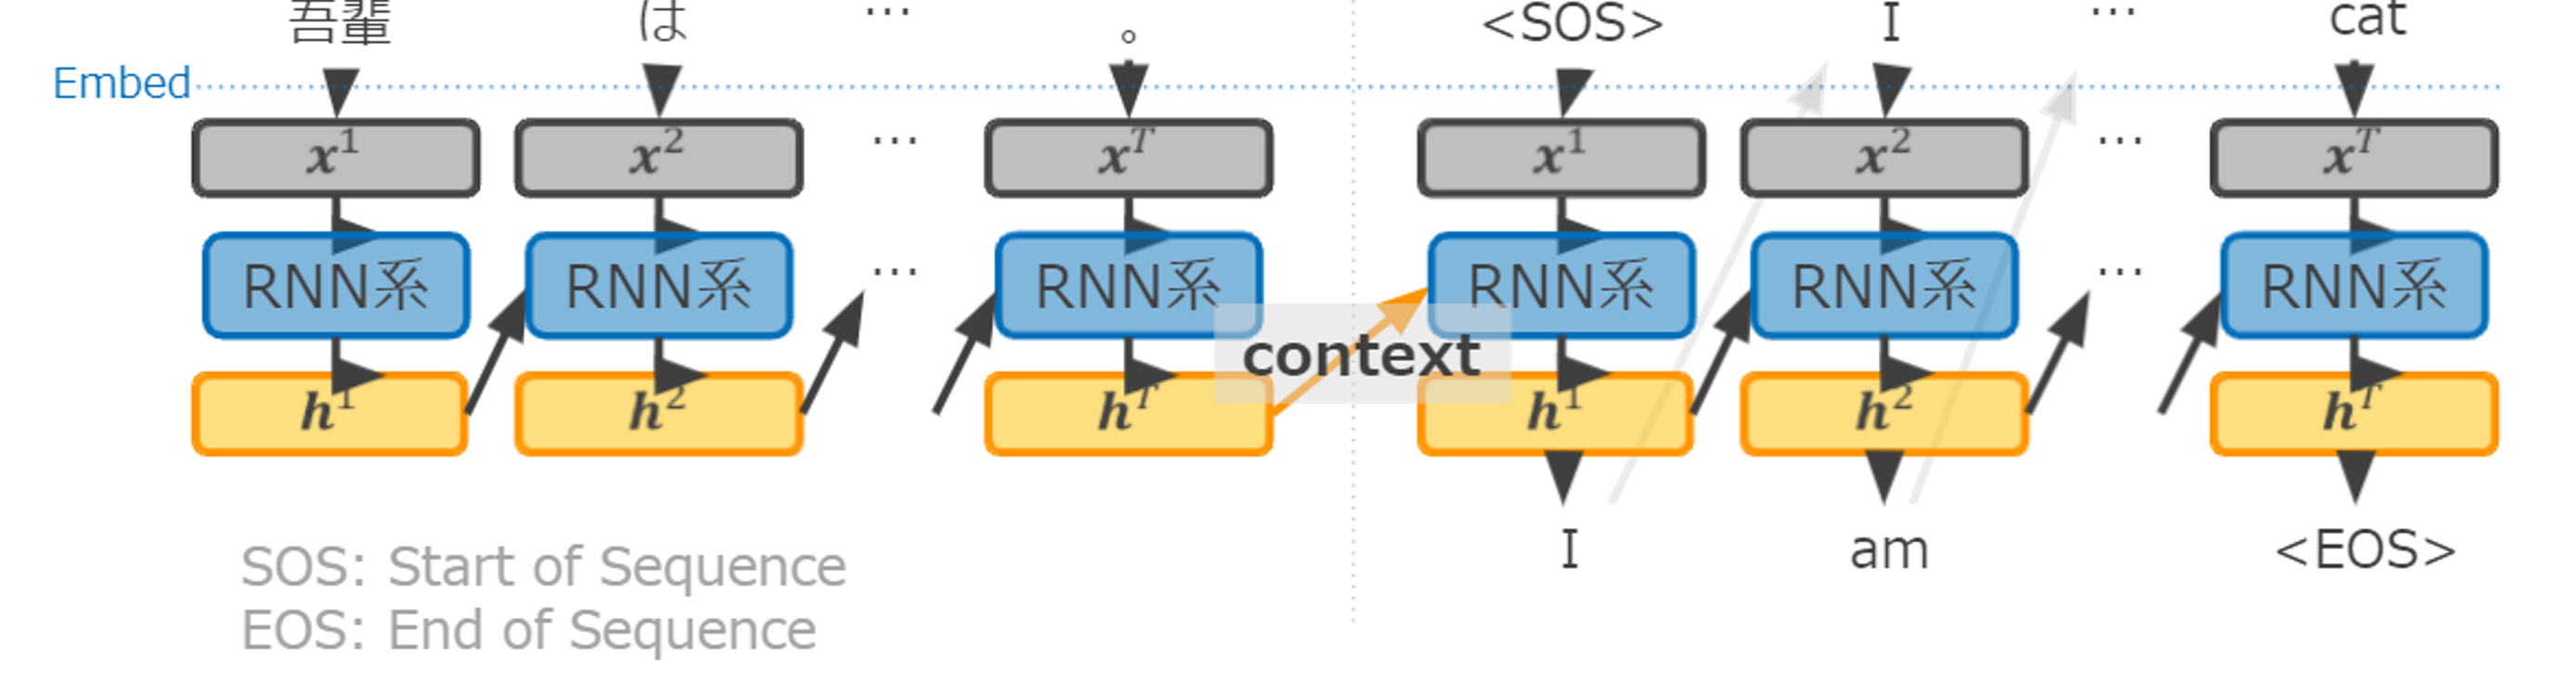

エンコーダ(Encoder)の構造は、下図のようになっています。

単語の埋め込みベクトルを順に入力し、隠れベクトルを得る仕組みになっています。

最初の隠れ状態には、初期値として0ベクトルなどが入力されることが多いです。

最後の単語に対応する隠れベクトルがエンコード結果となってデコーダーに送られます。


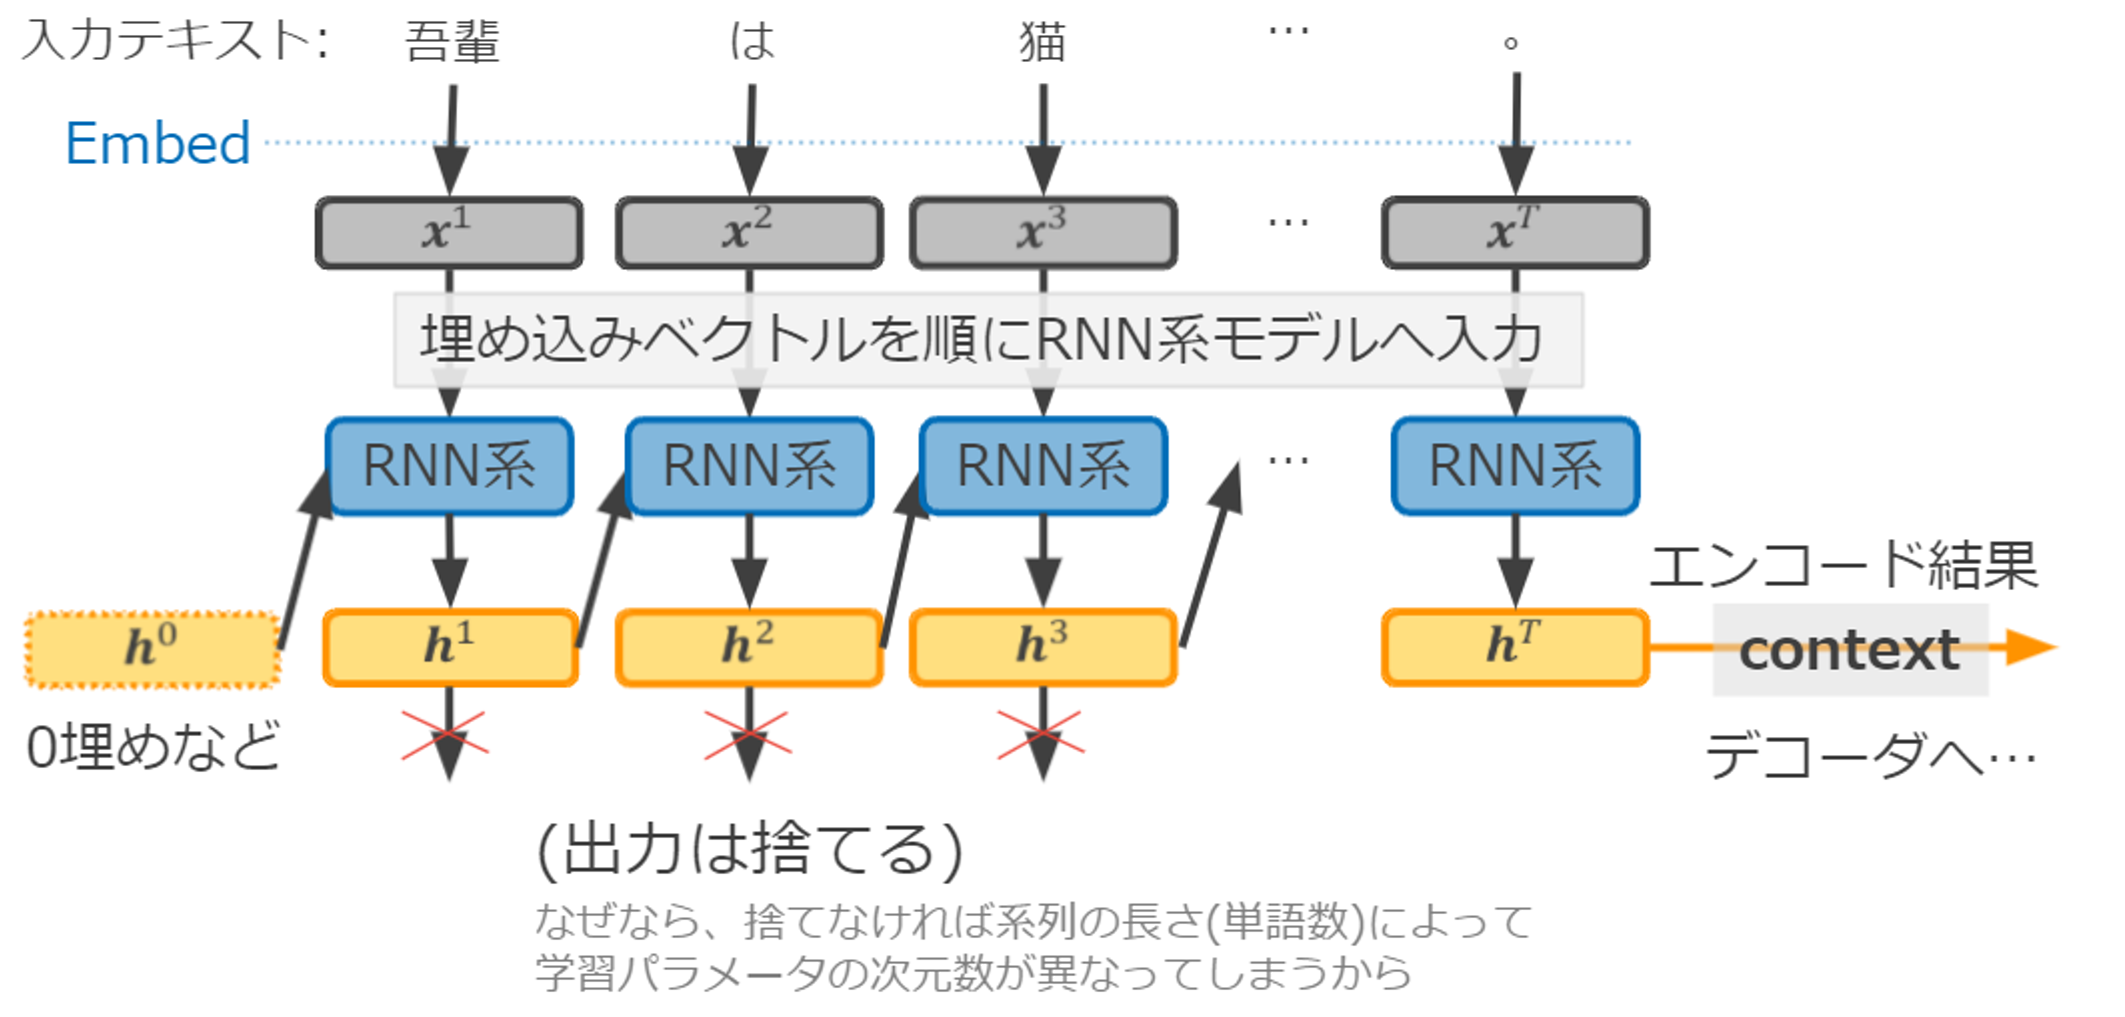

デコーダ(Decoder)の構造は、下図のようになっています。

隠れ状態としてエンコード結果を受け取ったRNNに、単語の埋め込みベクトルxを入力し,
各時刻の隠れベクトルhが得られます。

これが次に来る単語yを埋め込みベクトルの形で予測した値となります。

そのためエンコーダーでは途中の出力は捨てていましたが、デコーダーではすべての出力を使います。

この隠れベクトルhはそのままでは単語の予測に使えないので、確率ベクトルpの形に変換して次に来る単語を求めます。

隠れベクトルhを全結合層に通して1本のベクトルにしたのちに、ソフトマックス関数で語彙空間の確率分布に変換します。

その文書に出てくる全ての単語に対し、入力単語の次に来る確率を割り振ったベクトルがpとなります。

あとは確率が最大値となる単語を、入力単語の次に来る単語yとして出力します。

そしてその単語yの埋め込みベクトルを次の時刻のユニットに入力して、文章の終了までこれを繰り返します。


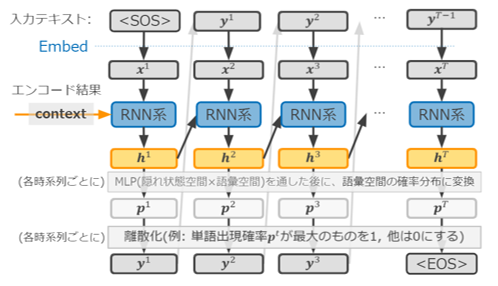

### Seq2Seqの用意

Seq2SeqのEncoderクラスとDecoderクラスを実装しましょう。それぞれの引数の説明は以下の通りです。
```
【Encoderクラスの引数】
  vocab_size    : 単語数
  embedding_dim : Embedding層の次元数
  enc_dim       : Encoderの出力の次元数

【Decoderクラスの引数】
 vocab_size     : 単語数
 embedding_dim  : Embedding層の次元数
 dec_dim        : Decoderの出力の次元数
```

* <font color="Red">問1-1, 1-2. 【Encoderクラス】`self.embedding`層と`self.lstm`層に当てはまる関数をTensorFlowを利用して実装しよう</font><br>
```
【ヒント➀】tensorflow.keras.layers.Embedding(input_dim, output_dim, mask_zero=False)の引数
  input_dim : 単語数
  output_dim  : Embedding層の次元数
  mask_zero    : Trueの場合、「0」を空白を表す特別なIDとして扱う
```
```
【ヒント➁】tensorflow.keras.layers.LSTM(units, return_sequence=False, return_state=False)の引数
  units  : LSTM層の出力サイズ
  return_sequences : 全てのLSTMの状態を返すかどうか。False: 最後のLSTM状態のみ。True: 途中のLSTM状態も含めて全て返す。
  return_state : 出力に加えて最後の状態を返すかどうか。False: 返さない、True: 返す
```

* <font color="Red">問2. 【Decoderクラス】出力に必要となる`self.dense`層をTensorFlowで完成させよう。活性化関数は線形関数を使用しよう。</font><br>

In [69]:
class Encoder:
    def __init__(self, vocab_size, embedding_dim, enc_dim):
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)### 問1-1 ###
        self.lstm = LSTM(enc_dim, return_sequences=False, return_state=True)### 問1-2 ###
    
    def __call__(self, x):
        embedding = self.embedding(x)
        _, hn, cn = self.lstm(embedding)
        return [hn, cn]

class Decoder:
    def __init__(self, vocab_size, embedding_dim, dec_dim):
        self.embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.lstm = LSTM(dec_dim, return_sequences=True, return_state=True)
        self.dense = Dense(vocab_size) ### 問2 ###
        
    def __call__(self, x, h):
        embedding = self.embedding(x)
        output, _, _ = self.lstm(embedding, initial_state=h)
        y = self.dense(output)
        return y

In [70]:
class Seq2SeqModel:
    def __init__(self, en_vocab_size, ja_vocab_size, embedding_dim, enc_dim, dec_dim):
        self.enc_input = Input(shape=(None,))
        self.dec_input = Input(shape=(None,))
        self.encoder = Encoder(en_vocab_size, embedding_dim, enc_dim)
        self.decoder = Decoder(ja_vocab_size, embedding_dim, dec_dim)
        
    def __call__(self):
        h = self.encoder(self.enc_input)
        y = self.decoder(self.dec_input, h)
        model = Model([self.enc_input, self.dec_input], y)
        return model

### 学習・評価

1エポックに10分ほどかかります。```n_epoch```の値は大きくしすぎないようにしましょう。

In [71]:
en_vocab_size = len(en_word_to_id) + 1
ja_vocab_size = len(ja_word_to_id) + 1
embedding_dim = 32
enc_dim = 16
dec_dim = 16
batch_size = 20
n_epoch = 3

model = Seq2SeqModel(en_vocab_size, ja_vocab_size, embedding_dim, enc_dim, dec_dim)()
model.compile(
    loss=lambda y_true, y_pred: tf.nn.softmax_cross_entropy_with_logits(tf.one_hot(tf.cast(y_true, tf.int32), ja_vocab_size), y_pred),
    optimizer = "Adam"
)

history = model.fit(
    x = [en_sentences, ja_sentences],
    y = ja_sentences,
    batch_size=batch_size,
    epochs=n_epoch,
    validation_split=0.2
)

Epoch 1/3
40/40 [==============================] - 8s 77ms/step - loss: 1.2113 - val_loss: 1.2808
Epoch 2/3
40/40 [==============================] - 1s 37ms/step - loss: 1.1422 - val_loss: 1.1604
Epoch 3/3
40/40 [==============================] - 2s 38ms/step - loss: 1.0158 - val_loss: 1.0784


## Attentionクラスの実装（スクラッチ）

これまでのSeq2Seqでは、Encoderの出力は「固定長のベクトル」でした。

現在のEncoderではどんなに長い文章であっても、固定長のベクトルへ変換しなければなりません。

Attention(注意機構)とはDecoderがEncoderの出力に注意(attention)を払う仕組みで、必要な情報に注意を向ける機構です。出力単語の予測に寄与する入力単語の情報を選ぶ機構です。

この機構によって、系列長に関係なくDecoderに情報伝達できます。

具体的には重み **a** によって必要な情報を抽出します。

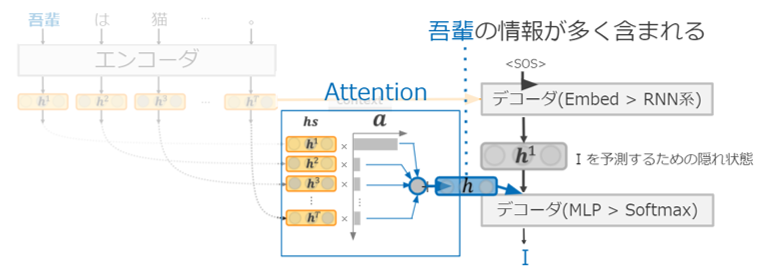

Attentionの重み **a**の算出方法には加法注意と内積注意の2種類あります。

加法注意(Additive Attention)は重み**a**を求めるために、隠れ層一つの順伝播型ニューラルネットワーク(FFN)を用います。


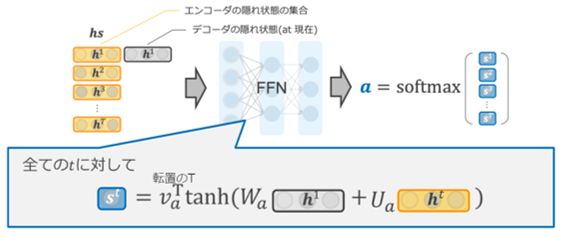

内積注意(Dot-Product Attention)は重み**a**を求めるために、内積を用います。

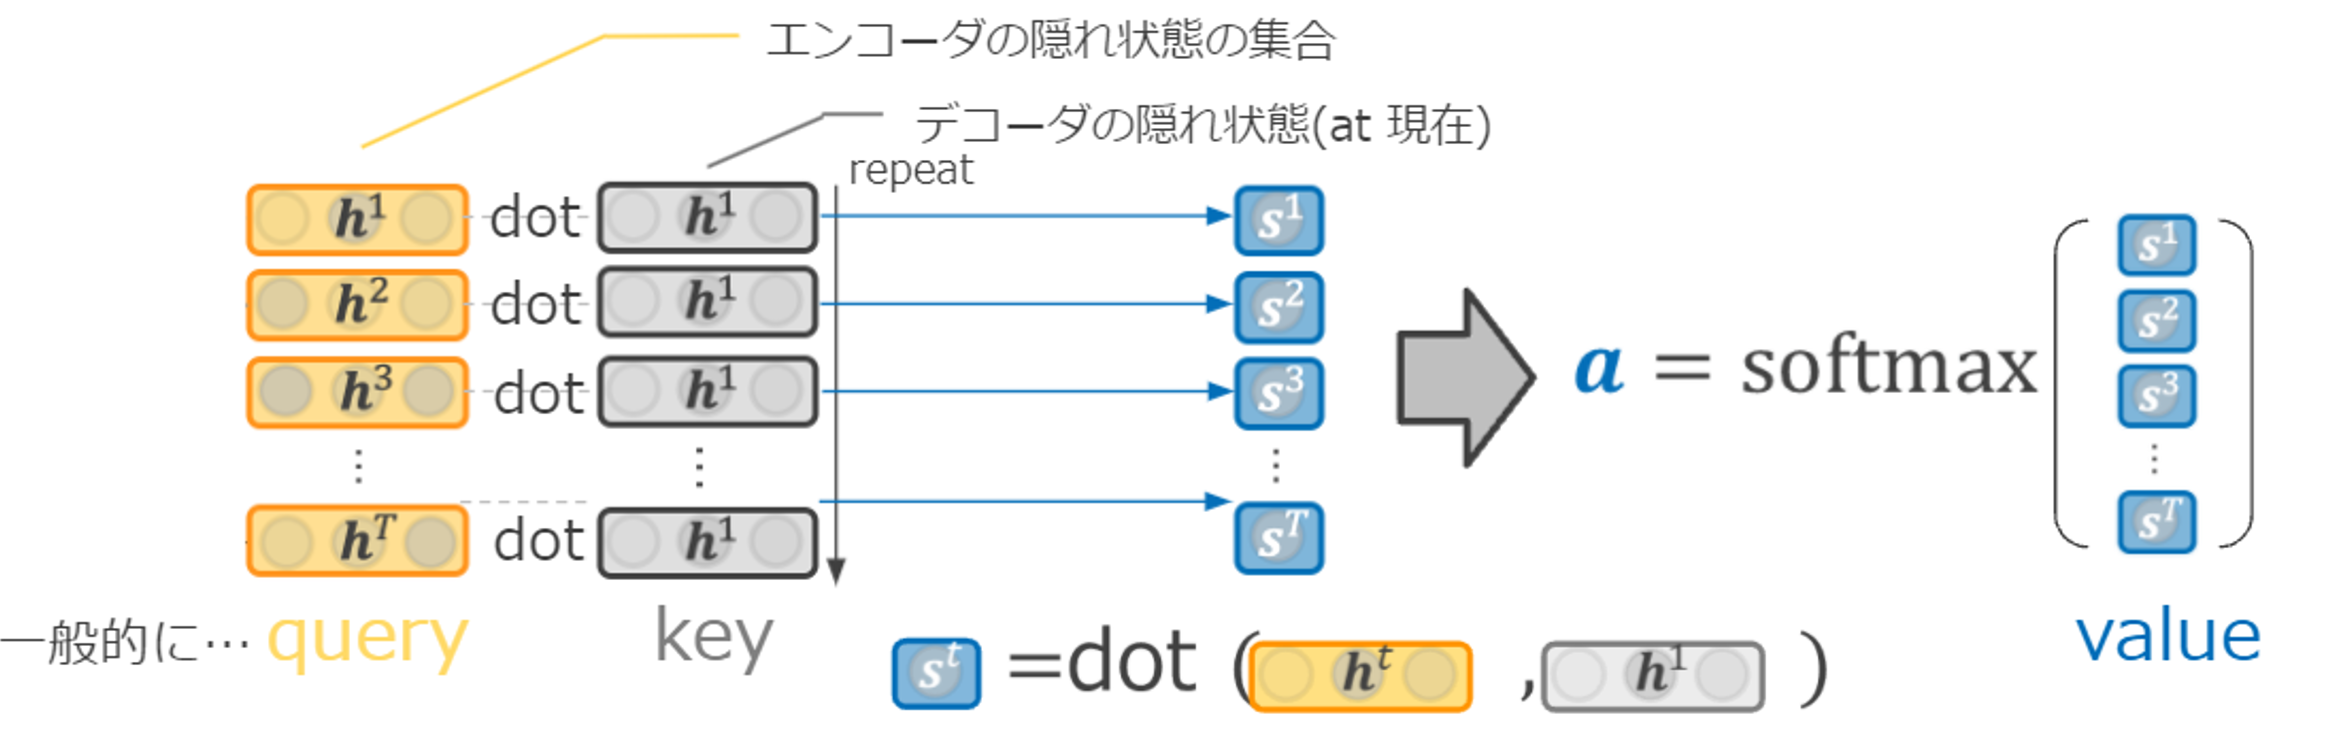

最終的に、加法注意もしくは内積注意で求めた重み**a**と

エンコーダの隠れ状態**hs**の内積をとり、重み付き和を計算します。

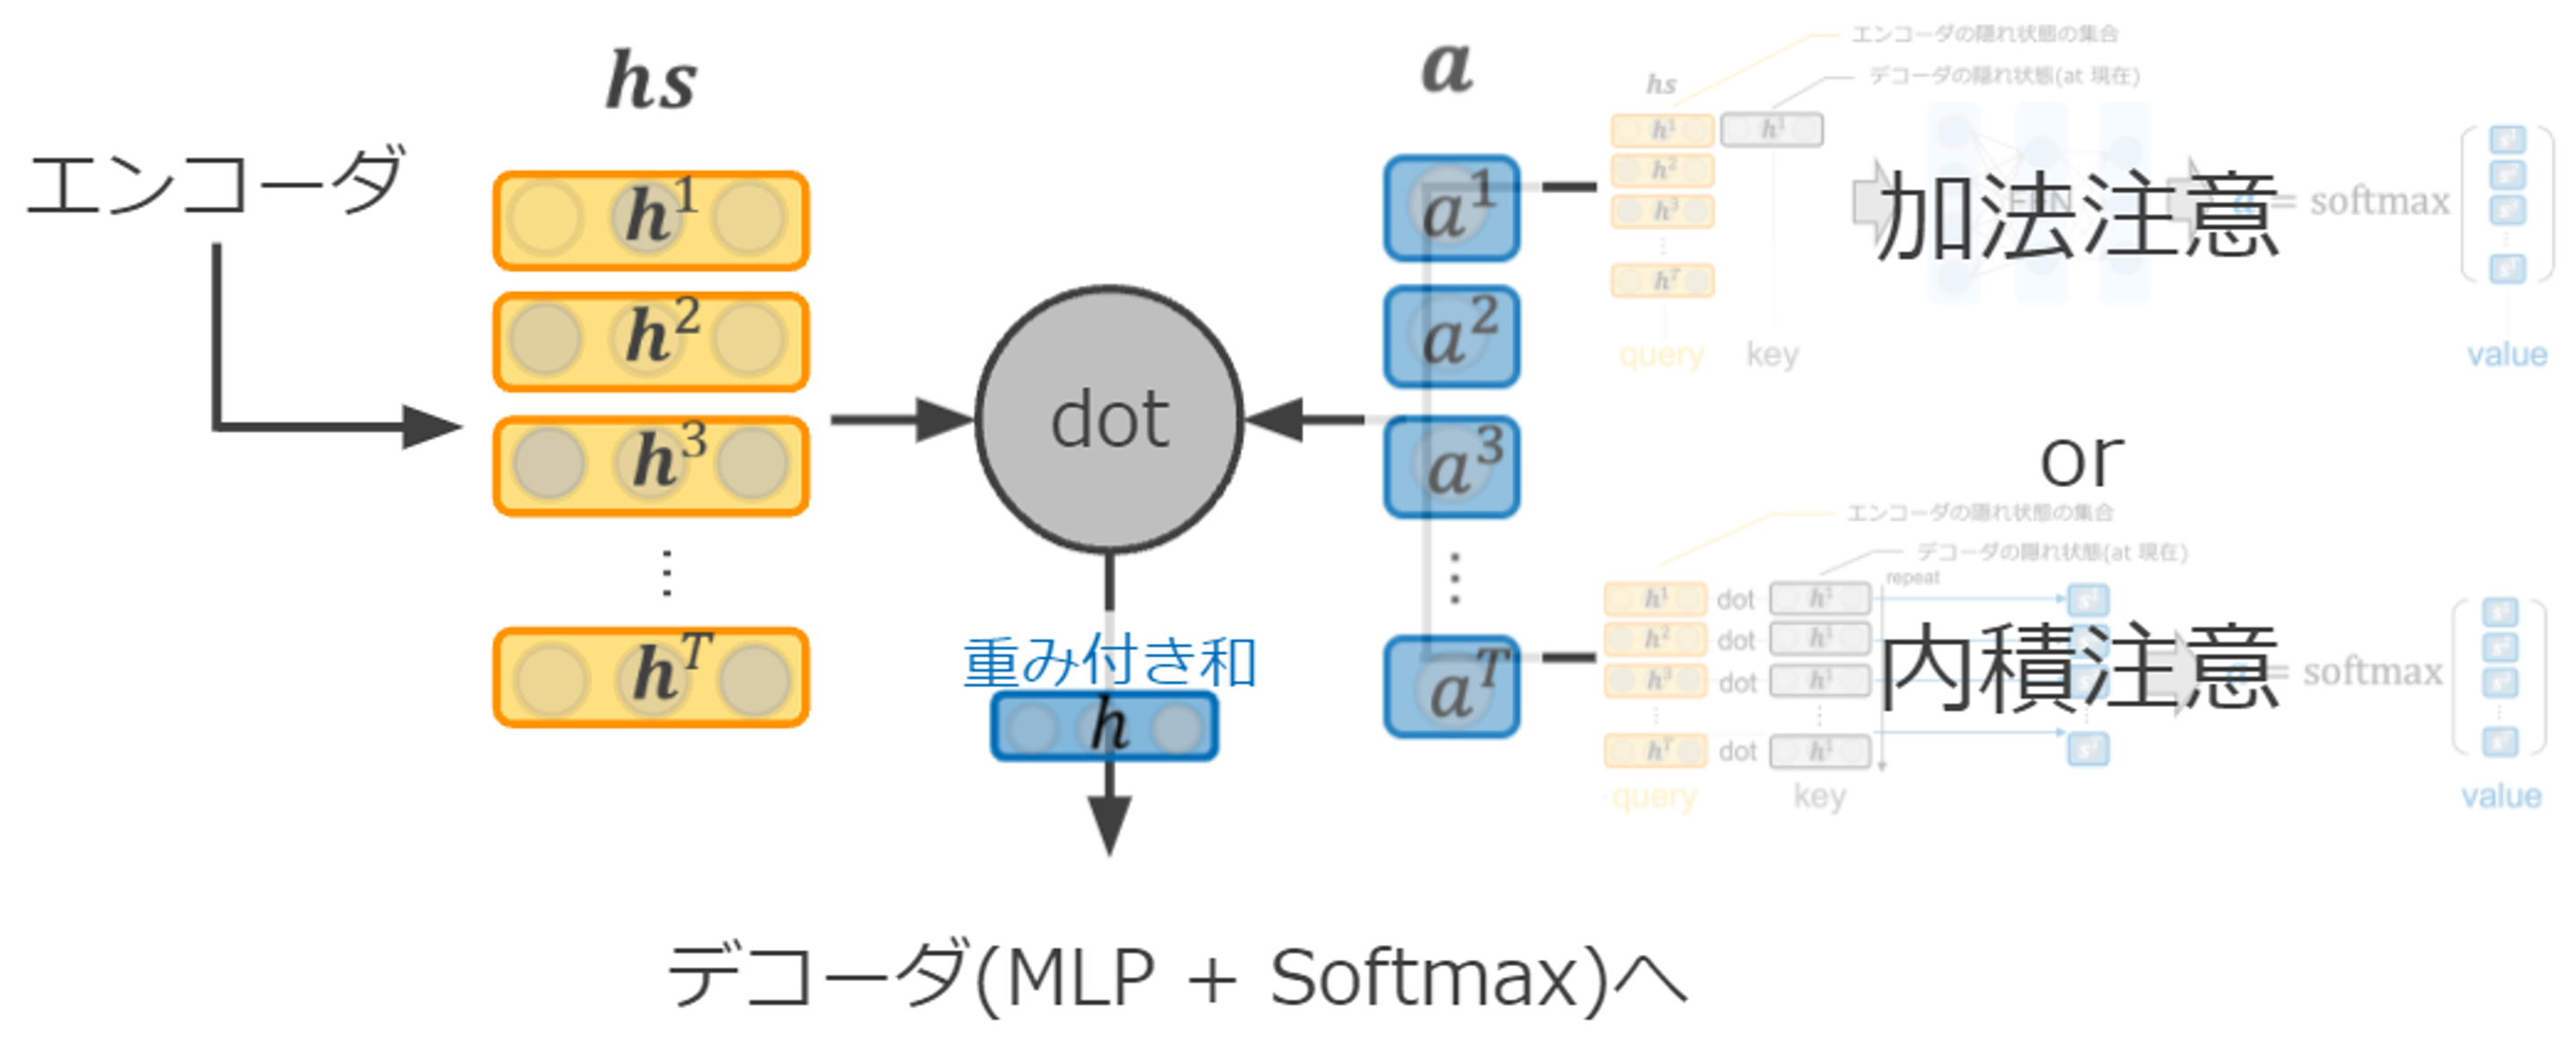

### 基本の関数

In [72]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

#### 内積注意(DotProductAttention)
* <font color="Red">問3. ```hs```をエンコーダーの隠れ状態、```hr```をデコーダーの隠れ状態とする。<br>この2つの内積を取って重みの種 **s** を出力するようなコードを記述しよう。</font><br>


In [73]:
# 内積注意(DotProductAttention)クラス
class DotProductAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.out = None
    
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t =  hs * hr ### 問3 ###
        s =  np.sum(t, axis=2)### 問3 ###
        a = softmax(s)
        self.out = a
        
        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = da * (1.0 - self.out) * self.out
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

#### 重み付き和の計算

* <font color="Red">問4. ```hs```をエンコーダーの隠れ状態、```ar```を問3で求めた重みとする。<br>この2つの内積を取って重み付き和 **c** を出力するようなコードを記述しよう。</font><br>

In [74]:
# 重み付き和の計算
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t =  hs * ar### 問4 ###
        c =  np.sum(t, axis=1)### 問4 ###
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)
        
        return dhs, da

### Attentionクラスの実装

上記の```DotProductAttention```と```WeightSum```を組み合わせてAttentionクラスとする。

In [75]:
# Attentionクラス
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_layer = DotProductAttention()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
    
    def forward(self, hs, h):
        a = self.attention_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

#### TimeAttentionクラス

6章で実装したTimeRNN層やTimeLSTM層と同様に、Attentionも多層化して時系列データに対応できるようにする。

In [76]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
    
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_enc.shape
        out = np.empty_like(hs_enc)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
        
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.numpy_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
        
        return dhs_enc, dhs_dec

## Transformerを用いた日英翻訳（TensorFlow）

"Transformer"とは、RNN・LSTMを使わずに、Attentionのみを使用したEncoder-Decoderモデルで計算量と精度を改善したモデルです。

さらに、RNN・LSTMを用いたSeq2seqでは不可能であった並列計算が可能になりました。

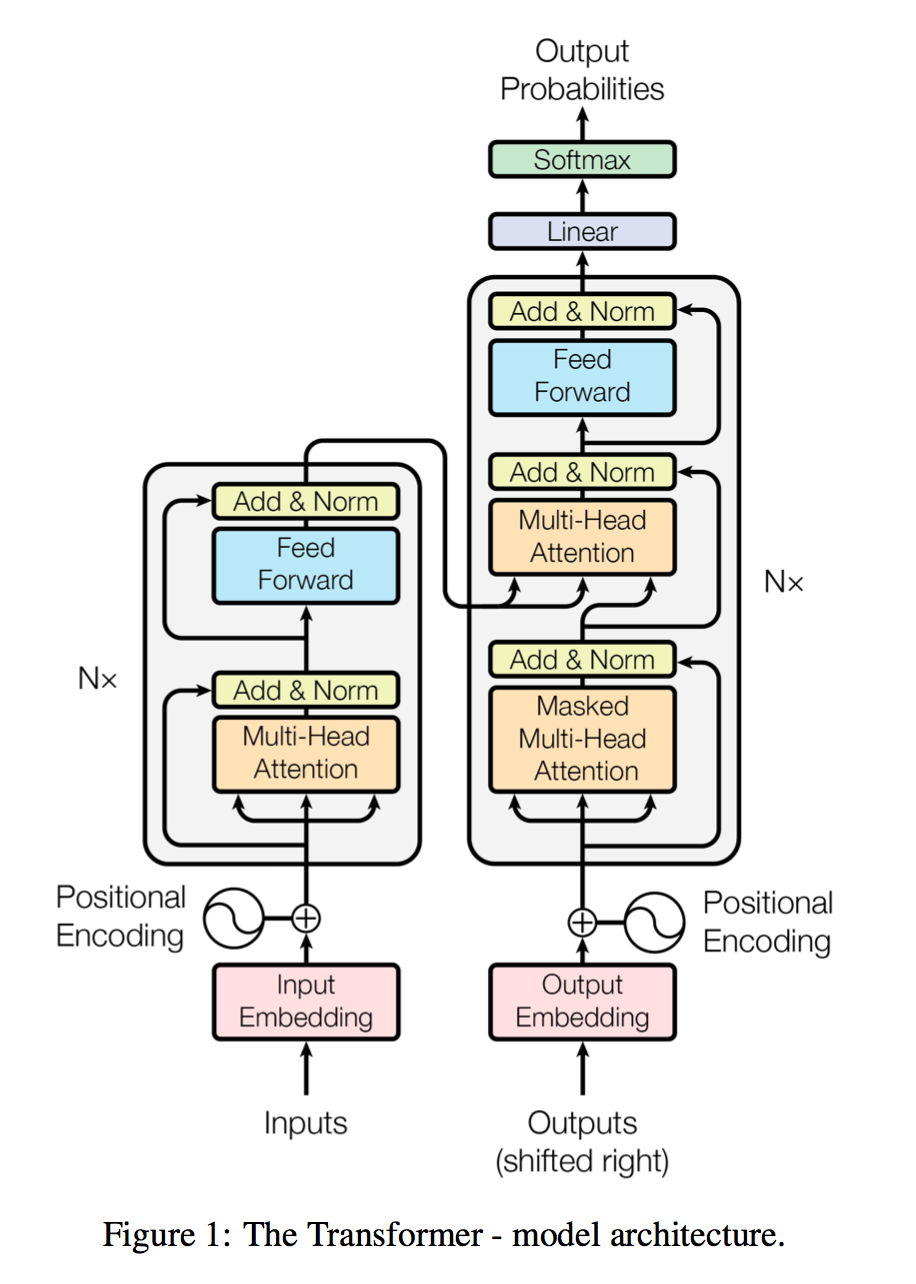


### Embeddingクラス

Embedingクラスでは単語をベクトルに変換します。

単語の意味を保ちながら数値に変換することが出来ます。

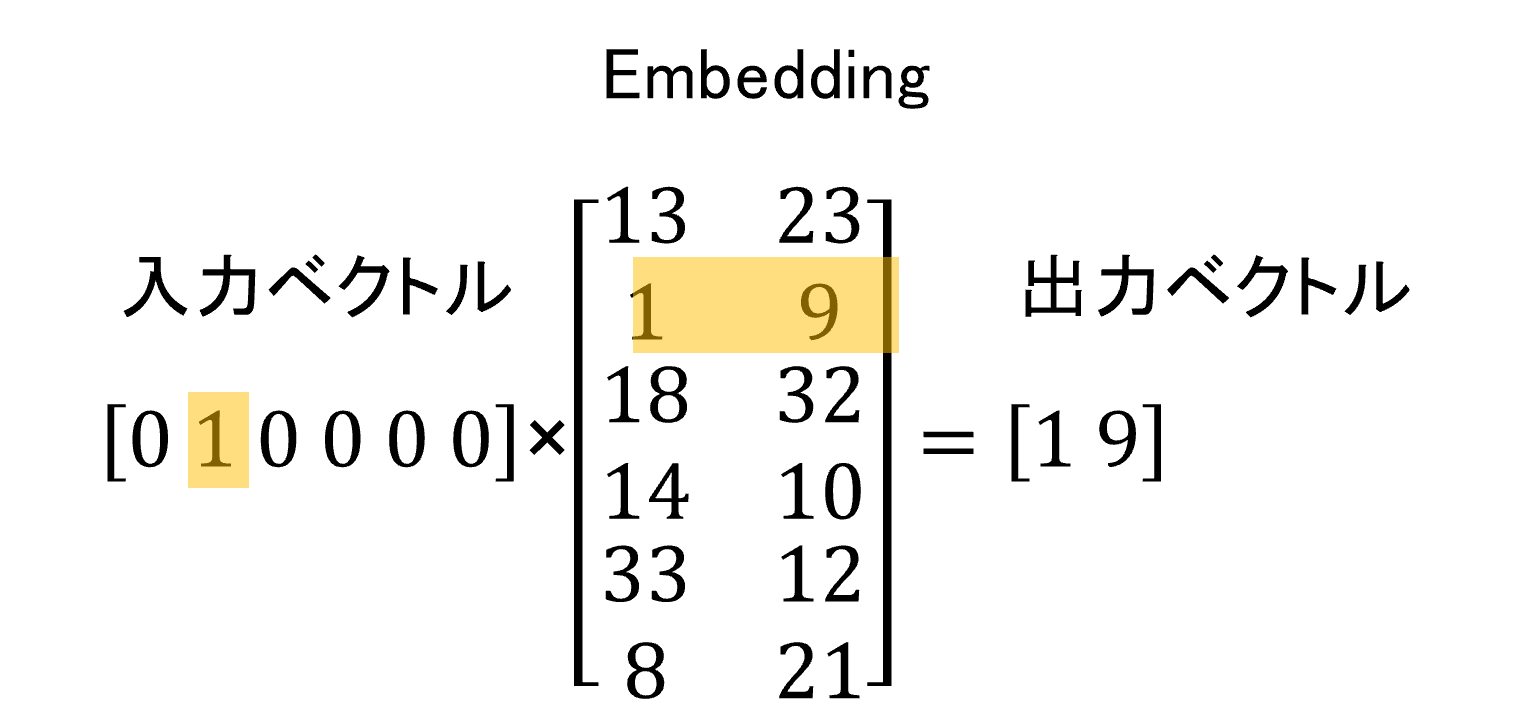

In [130]:
class Embedder:
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = Embedding(vocab_size, d_model)
    def __call__(self, x):
        return self.embed(x)

### Normクラス

入力を正規化するNormクラスを実装します。

Transformerではレイヤー正規化（Layer Normalization）を行います。

層単位で全チャンネル(ノード)に対する正規化を行います。これにより，各ステップで層ごとに正規化でき、可変長入力にも問題なく対応できます。

正規化の為の式は以下の通りです。

<br>

$\mu^l = \frac{1}{H}\sum_{i=1}^H{x^l_i}$ ・・・レイヤーの平均

$\sigma^l = \sqrt{\frac{1}{H}\sum_{i=1}^H{(x^l_i - \mu^l)^2}}$ ・・・レイヤーの標準偏差

$\hat{x^l_i} = \frac{x^l_i - \mu^l}{\sigma^l + \epsilon}$ ・・・正規化

$\mathrm{norm} = \alpha \hat{x^l_i} + \beta$ ・・・スケール変換と移動
<br>
<br>
* <font color="Red">問5. `alpha` と `bias` はNormクラスで正規化する際のパラメータ、`eps` は正規化のゼロ除算を防ぐための定数である。正規化した値 **Norm** を計算するコードを記述しよう。</font><br>

【補足】ゼロ除算を防ぐ＝標準偏差に `eps` を加えた値で割る

In [131]:
class Norm:
    def __init__(self, d_model, eps=1e-6):    
        self.size = d_model
        self.alpha = tf.Variable(tf.ones(self.size))
        self.bias = tf.Variable(tf.zeros(self.size))
        self.eps = eps

    def __call__(self, x):
        norm = self.alpha * ((x - tf.math.reduce_mean(x, axis=-1, keepdims=True))/tf.sqrt(tf.math.reduce_std(x, axis=-1, keepdims=True) + self.eps))+ self.bias ### 問5 ###
        return norm

### PositionalEncoderクラス

Positional Encodersとは単語の順序・位置関係を考慮する技術です。

Attentionのみでは単語の順序を考慮して学習できません。
```
【例】
  ・吾輩は猫である
  ・猫は吾輩である
  この2つを異なる文として学習できない
```
そのため、Positional Encodersでは「位置ベクトル」を埋め込みベクトルに足し、単語同士の相対的な位置関係を規定できるようにします。

ここで、位置ベクトルは以下の式で算出されます。

$$
PE_{\rm{pos}, 2i} = \sin\frac{\rm{pos}}{10000^\frac{2i}{d}}
$$
$$
PE_{\rm{pos}, 2i+1} = \cos\frac{\rm{pos}}{10000^\frac{2i}{d}}
$$

* <font color="Red">問6-1, 6-2. ```math.sin```関数もしくは```math.cos```関数を使って、時系列の深さを$i$としたときのPositionalEncoderの出力をコードで記述しよう。<br>なお```d_model```はモデルの次元である。</font>

    【ヒント】`range` 関数の第3引数は取り出される数列の公差を指定します。そのため、`for i in range(start, stop, 2)` というコードで定義される変数 `i` は位置ベクトルの式にある $2i$ に対応します。

In [132]:
class PositionalEncoder:
    def __init__(self, d_model, max_seq_len=80):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.pe = tf.Variable(tf.zeros([self.max_seq_len, self.d_model]))
        for pos in range(self.max_seq_len):
            for i in range(0, self.d_model, 2):
                
                self.pe = self.pe[pos, i].assign(
                    math.sin(pos/10000**(i/d_model))### 問6-1 ###
                )
                self.pe = self.pe[pos, i+1].assign(
                    math.cos(pos/10000**(i/d_model))### 問6-2 ###
                )
        self.pe = tf.reshape(self.pe, [1, self.max_seq_len, self.d_model])
        tf.cast(self.pe, dtype=tf.float32)
    
    def __call__(self, x):
        seq_len = tf.shape(x)[1]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pe[:, :seq_len, :]
        return x

### creating_masks関数

In [133]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shapeは(seq_len, seq_len)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # shapeは(batch_size, 1, 1, seq_len)


def creating_masks(src, trg):
    enc_padding_mask = create_padding_mask(src)
    dec_padding_mask = create_padding_mask(src)
    look_ahead_mask = create_look_ahead_mask(tf.shape(trg)[1])
    dec_target_padding_mask = create_padding_mask(trg)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

### MultiHeadAttentionクラス

Attentionを複数重ねたものがMultiHeadAttentionとなります。
TransformerではAttentionとして内積注意が用いられています。

In [134]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [135]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def __call__(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) 
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

### FeedForwardクラス

In [136]:
def FeedForward(d_model, dff):
    return Sequential([
        Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

### EncoderLayerクラス, DecoderLayerクラス

NormクラスとMultiHeadAttentionクラス、FeedForwardクラスを重ねて、Dropout層を追加する。

エンコーダーとデコーダーでDropoutの位置が違うので注意だ。

In [137]:
class EncoderLayer:
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, dff)
        self.layernorm1 = Norm(d_model, eps=1e-6)
        self.layernorm2 = Norm(d_model, eps=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def __call__(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        norm_output = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(norm_output)
        drp_output = self.dropout2(ffn_output)
        y = self.layernorm2(norm_output + drp_output)
        return y
    
class DecoderLayer:
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, dff)
        self.layernorm1 = Norm(d_model, eps=1e-6)
        self.layernorm2 = Norm(d_model, eps=1e-6)
        self.layernorm3 = Norm(d_model, eps=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

    def __call__(self, x, enc_output, look_ahead_mask, padding_mask):

        attn_output, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        drp_output = self.dropout1(attn_output)
        norm_output = self.layernorm1(drp_output + x)
        attn_output, attn_weights_block2 = self.mha2(enc_output, enc_output, norm_output, padding_mask)
        drp_output = self.dropout2(attn_output)
        norm_output = self.layernorm2(drp_output + norm_output)

        ffn_output = self.ffn(norm_output)
        ffn_output = self.dropout3(ffn_output)
        y = self.layernorm3(ffn_output + norm_output)

        return y, attn_weights_block1, attn_weights_block2

### Encoderクラス, Decoderクラス

EmbedderとPositionalEncoderを組み合わせて、EncoderLayer及びDecoderLayerをそれぞれ多層化する。

In [138]:
class Encoder:
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_seq_len, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedder(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoder(self.d_model, max_seq_len)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def __call__(self, x, mask):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)
        return x



class Decoder:
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_seq_len, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedder(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoder(self.d_model, max_seq_len)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def __call__(self, x, enc_output, look_ahead_mask, padding_mask):
        attention_weights = {}
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
        attention_weights[f'decoder_layer{i+1}_block1'] = block1
        attention_weights[f'decoder_layer{i+1}_block2'] = block2
        return x, attention_weights

### Transformerクラス

構築したEncoderとDecoderを結合して、1つのモデルにする。

In [139]:
class Transformer:
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        self.enc_input = Input(shape=(None,))
        self.dec_input = Input(shape=(None,))
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = Dense(target_vocab_size)

    def __call__(self):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = creating_masks(self.enc_input, self.dec_input, )
        enc_output = self.encoder(self.enc_input, enc_padding_mask)
        dec_output, attention_weights = self.decoder(self.dec_input, enc_output, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        model = Model([self.enc_input, self.dec_input], final_output)
        return model

### 学習

以下の設定で学習させます。今回は学習の流れを体験することが目的なので、1エポックだけ回します。

精度を上げたい場合は```embedding_dim```や```hidden_dim```を調整します。

学習速度を上げたい場合は```batch_size```を調整しましょう。

- 埋め込み次元：embedding_dim = 32

- 隠れ層の次元：hidden_dim = 16

- バッチサイズ：batch_size = 10

- Encoder, Decoderの数：N = 2 

- Attentionの数：HEADS = 2 

In [140]:
src_vocab = len(en_id_to_word) + 1
trg_vocab = len(ja_id_to_word) + 1
en_seq_len = en_sentences.shape[1]
ja_seq_len = ja_sentences.shape[1]
hidden_dim = 16 #PCスペックに対して重すぎる場合は下げる
N = 2 #Encoder, Decoderの数
HEADS = 2 #Attentionの数
batch_size = 10
n_epoch = 1

model = Transformer(
    num_layers=N,
    d_model=hidden_dim,
    num_heads=HEADS,
    dff=2048,
    input_vocab_size=src_vocab,
    target_vocab_size=trg_vocab,
    pe_input=en_seq_len,
    pe_target=ja_seq_len,
    rate=0.1)()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none'),
    optimizer = "Adam"
)

history = model.fit(
    x = [en_sentences, ja_sentences],
    y = ja_sentences,
    batch_size=batch_size,
    epochs=n_epoch,
    validation_split=0.2
)

80/80 [==============================] - 8s 54ms/step - loss: 3.2984 - val_loss: 2.3736


これで問題は以上です。お疲れ様でした。

学習が成功したら、ノートブックを提出してください。